Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

Copy modified by Marco Riggio

In [194]:
from math import sqrt
from itertools import permutations
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [195]:
class Tsp:

    def __init__(self, num_cities: int, seed: Any = None) -> None:
        '''Defines a Tsp object, that is a random graph where the number of nodes is equal
        to num_cities parameter. A seed parameter for randomness can be specified.'''
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()  # Creates a directed graph
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))   #Adds a node to the graph, in a random position

    def distance(self, n1, n2) -> int:
        ''':return An integer with the euclidean distance between two nodes'''
        pos1 = self._graph.nodes[n1]['pos']
        pos2 = self._graph.nodes[n2]['pos']
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0])**2 +
                                                         (pos1[1] - pos2[1])**2))

    def evaluate_solution(self, solution: np.array) -> float:
        ''':return A float with the total lenght of the path'''
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def plot(self, path: np.array = None) -> None:
        '''Plots the graph of a Tsp object. The path parameter contains edges, which is an
        ordered list of nodes.'''
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(self._graph,
                pos=nx.get_node_attributes(self._graph, 'pos'),
                with_labels=True,
                node_color='pink')
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

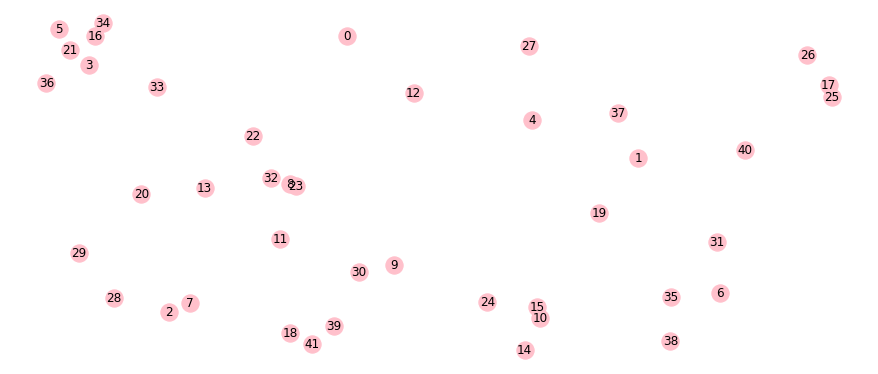

In [196]:
NUM_CITIES = 42

problem = Tsp(NUM_CITIES)
problem.plot()

## Simulated Annealing

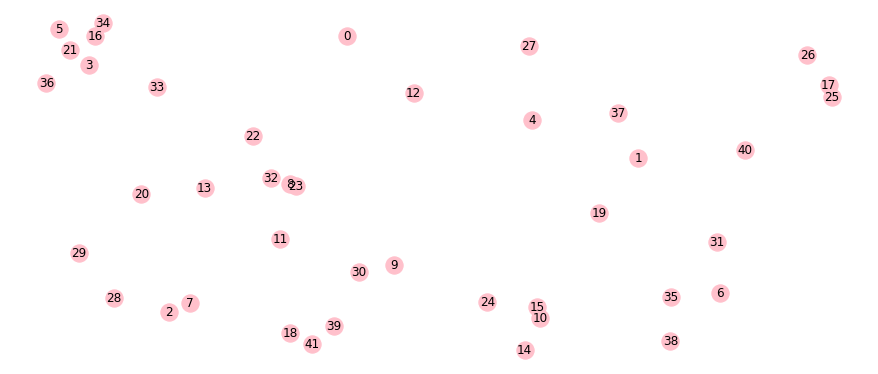

In [ ]:
def tweak(solution: np.array,) -> np.array:
    new_solution = solution.copy()
    i1 = np.random.randint(0, NUM_CITIES)
    i2 = np.random.randint(0, NUM_CITIES)
    temp = new_solution[i1]
    new_solution[i1] = new_solution[i2]
    new_solution[i2] = temp
    p = np.random.random()
    return new_solution


actual_solution = np.array(range(NUM_CITIES))
np.random.shuffle(actual_solution)
best_solution = actual_solution
actual_solution_cost = problem.evaluate_solution(actual_solution)
best_solution_cost = actual_solution_cost
problem.plot()

history = [(0, actual_solution_cost)]
temperature = 5000
final_temperature = 0
decrease_rate = 0.01
step = 0
STEADY_STATE = 1000000
steady_state = 0

while temperature > final_temperature and steady_state<STEADY_STATE:
    #print(f"Evaluation at temperature {temperature}")
    step += 1
    steady_state += 1
    new_solution = tweak(actual_solution)
    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < actual_solution_cost:
        actual_solution = new_solution
        actual_solution_cost = new_solution_cost
        history.append((step, actual_solution_cost))
        temperature -= decrease_rate
        steady_state = 0
    elif np.random.rand() < np.exp((actual_solution_cost - new_solution_cost) / temperature):
        actual_solution = new_solution
        actual_solution_cost = new_solution_cost
        history.append((step, actual_solution_cost))
        temperature -= decrease_rate

    if new_solution_cost < best_solution_cost:
        best_solution = new_solution
        best_solution_cost = actual_solution_cost



problem.plot(best_solution)
history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history, '.')
print(f"final cost: {bestt_solution_cost}")


